# DeepONet: Operator Learning with Neural Networks

**Learning Objectives:**
- Understand the leap from function approximation to operator learning
- Master the Universal Approximation Theorem for Operators
- Learn the DeepONet architecture: Branch and Trunk networks
- Implement operator learning for the derivative operator
- Apply DeepONet to the 1D nonlinear Darcy problem

**Exercise:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml-sciml/blob/main/docs/02-deeponet/deeponet-exercise.ipynb)
**Solution:** [![Open in Colab](https://img.shields.io/badge/Open%20in-Colab-F9AB00?style=flat-square&logo=googlecolab)](https://colab.research.google.com/github/kks32-courses/sciml-sciml/blob/main/docs/02-deeponet/deeponet.ipynb)


**Slides:** [![View PDF](https://img.shields.io/badge/View-PDF-red?style=flat-square&logo=googledocs&logoColor=white)](https://github.com/kks32-courses/sciml-sciml/raw/main/docs/02-deeponet/deeponet-slides.pdf)
---

## The Fundamental Question

We've learned how neural networks can approximate **functions**: $f: \mathbb{R}^d \rightarrow \mathbb{R}^m$.

**But what if we want to learn mappings between infinite-dimensional function spaces?**

Enter **operators**: mappings that take functions as input and produce functions as output.

$$\mathcal{G}: \mathcal{A} \rightarrow \mathcal{U}$$

where $\mathcal{A}$ and $\mathcal{U}$ are function spaces.

**Examples of operators:**

-   **Derivative operator:** $\mathcal{G}u = \frac{du}{dx}$
-   **Integration operator:** $\mathcal{G}f = \int_0^x f(t) dt$
-   **PDE solution operator:** Given boundary conditions or source terms, map to the PDE solution.

---

## The Challenge with Traditional Neural Networks

Standard neural networks learn point-wise mappings: $\mathbb{R}^n \rightarrow \mathbb{R}^m$. But operators map functions to functions. How do we represent infinite-dimensional functions with finite data?

**Traditional approach limitations:**

-   **Fixed discretization:** Networks trained on specific grids can't generalize to different resolutions.
-   **Curse of dimensionality:** High-dimensional function spaces are computationally intractable.
-   **No theoretical foundation:** No guarantee that standard networks can approximate operators.

In [14]:
import numpy as np
import warnings
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

warnings.filterwarnings('ignore')

# Set style and random seeds
np.random.seed(42)
torch.manual_seed(42)

# Device selection
def get_device():
    if torch.cuda.is_available():
        return torch.device("cuda")
    elif torch.backends.mps.is_available():
        return torch.device("mps")
    else:
        return torch.device("cpu")

device = get_device()
print(f"Using device: {device}")

Using device: mps


## From Scalars to Functions - The Conceptual Leap

Let's start with something familiar and build our intuition.

### Traditional Function Approximation

We know neural networks can learn mappings like:
- **Input:** A number $x = 2.5$
- **Output:** A number $f(x) = x^2 = 6.25$

This is **point-wise mapping**: each input point maps to an output point.

### Operator Learning: The Next Level

Now imagine:
- **Input:** An entire function $u(x) = \sin(x)$
- **Output:** Another entire function $\mathcal{G}[u](x) = \cos(x)$ (the derivative!)

This is **function-to-function mapping**: each input function maps to an output function.

**Examples of operators we encounter in science:**
1. **Derivative operator:** $\mathcal{D}[u] = \frac{du}{dx}$
2. **Integration operator:** $\mathcal{I}[f] = \int_0^x f(t) dt$
3. **PDE solution operator:** Given source $f$, return solution $u$ of $\nabla^2 u = f$

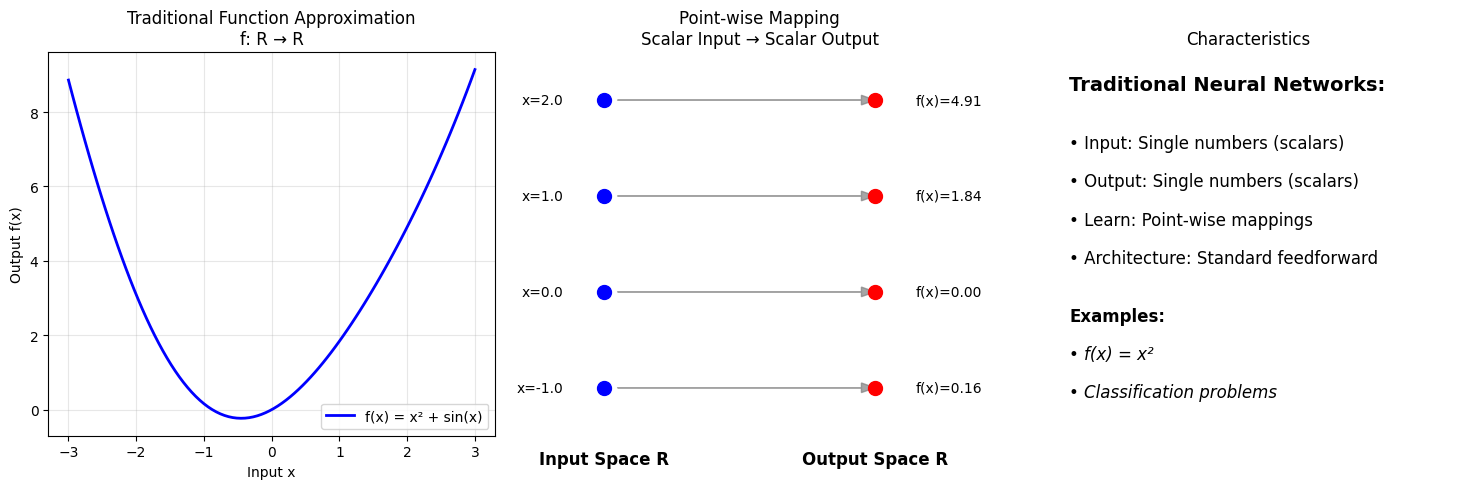

Traditional Function Approximation:
• Takes individual points as input
• Produces individual points as output
• Neural network learns: x → f(x)
• This is what we're familiar with!


In [15]:
def demonstrate_function_approximation():
    """Show traditional function approximation with clearer visualization"""
    
    # Example: Learn f(x) = x² + sin(x)
    x = np.linspace(-3, 3, 100)
    y = x**2 + np.sin(x)
    
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Traditional function plot
    plt.subplot(1, 3, 1)
    plt.plot(x, y, 'b-', linewidth=2, label='f(x) = x² + sin(x)')
    plt.title('Traditional Function Approximation\nf: R → R')
    plt.xlabel('Input x')
    plt.ylabel('Output f(x)')
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    # Plot 2: Point-wise mapping visualization (improved)
    plt.subplot(1, 3, 2)
    
    # Show specific input-output pairs
    sample_x = np.array([-1.0, 0.0, 1.0, 2.0])
    sample_y = sample_x**2 + np.sin(sample_x)
    
    # Create a clearer mapping visualization
    input_positions = np.arange(len(sample_x))
    output_positions = np.arange(len(sample_x)) + 0.5
    
    # Plot input values
    for i, (xi, yi) in enumerate(zip(sample_x, sample_y)):
        # Input side
        plt.scatter(0, input_positions[i], s=100, c='blue', zorder=5)
        plt.text(-0.3, input_positions[i], f'x={xi:.1f}', ha='right', va='center')
        
        # Output side  
        plt.scatter(2, input_positions[i], s=100, c='red', zorder=5)
        plt.text(2.3, input_positions[i], f'f(x)={yi:.2f}', ha='left', va='center')
        
        # Arrow showing mapping
        plt.arrow(0.1, input_positions[i], 1.8, 0, 
                 head_width=0.1, head_length=0.1, fc='gray', ec='gray', alpha=0.7)
    
    plt.xlim(-0.5, 2.8)
    plt.ylim(-0.5, len(sample_x) - 0.5)
    plt.title('Point-wise Mapping\nScalar Input → Scalar Output')
    plt.text(0, -0.8, 'Input Space R', ha='center', fontsize=12, fontweight='bold')
    plt.text(2, -0.8, 'Output Space R', ha='center', fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Plot 3: Characteristics
    plt.subplot(1, 3, 3)
    plt.text(0.1, 0.9, 'Traditional Neural Networks:', fontsize=14, fontweight='bold', 
             transform=plt.gca().transAxes)
    plt.text(0.1, 0.75, '• Input: Single numbers (scalars)', fontsize=12, 
             transform=plt.gca().transAxes)
    plt.text(0.1, 0.65, '• Output: Single numbers (scalars)', fontsize=12, 
             transform=plt.gca().transAxes)
    plt.text(0.1, 0.55, '• Learn: Point-wise mappings', fontsize=12, 
             transform=plt.gca().transAxes)
    plt.text(0.1, 0.45, '• Architecture: Standard feedforward', fontsize=12, 
             transform=plt.gca().transAxes)
    plt.text(0.1, 0.3, 'Examples:', fontsize=12, fontweight='bold', 
             transform=plt.gca().transAxes)
    plt.text(0.1, 0.2, '• f(x) = x²', fontsize=12, 
             transform=plt.gca().transAxes, style='italic')
    plt.text(0.1, 0.1, '• Classification problems', fontsize=12, 
             transform=plt.gca().transAxes, style='italic')
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.axis('off')
    plt.title('Characteristics')
    
    plt.tight_layout()
    plt.show()
    
    print("Traditional Function Approximation:")
    print("• Takes individual points as input")
    print("• Produces individual points as output") 
    print("• Neural network learns: x → f(x)")
    print("• This is what we're familiar with!")

demonstrate_function_approximation()

### Operator Learning

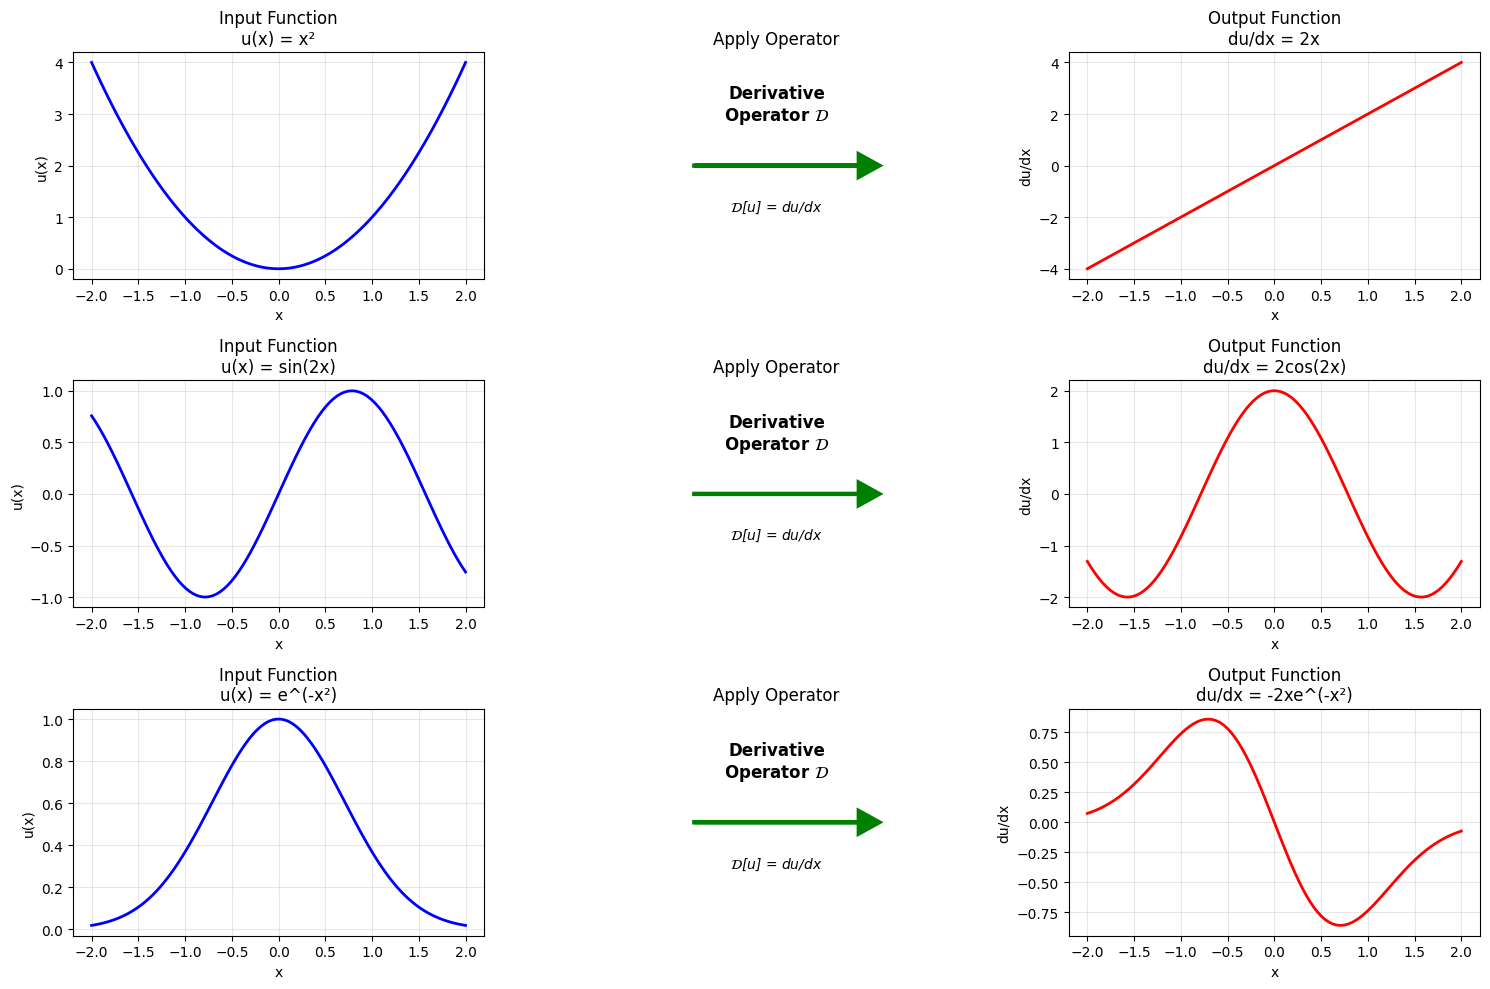

Key Insight: An operator takes a FUNCTION as input and produces a FUNCTION as output!
This is fundamentally different from traditional function approximation.


In [28]:
def demonstrate_operator_concept():
    """Demonstrate the concept of operators"""
    
    x = np.linspace(-2, 2, 100)
    
    # Three different input functions
    u1 = x**2
    u2 = np.sin(2*x)
    u3 = np.exp(-x**2)
    
    # The derivative operator D applied to each
    du1_dx = 2*x
    du2_dx = 2*np.cos(2*x)
    du3_dx = -2*x*np.exp(-x**2)
    
    plt.figure(figsize=(15, 10))
    
    # Show operator concept
    for i, (u, du_dx, title) in enumerate([(u1, du1_dx, 'u(x) = x²'), 
                                           (u2, du2_dx, 'u(x) = sin(2x)'),
                                           (u3, du3_dx, 'u(x) = e^(-x²)')]):
        
        plt.subplot(3, 3, 3*i + 1)
        plt.plot(x, u, 'b-', linewidth=2)
        plt.title(f'Input Function\n{title}')
        plt.xlabel('x')
        plt.ylabel('u(x)')
        plt.grid(True, alpha=0.3)
        
        plt.subplot(3, 3, 3*i + 2)
        plt.arrow(0.3, 0.5, 0.4, 0, head_width=0.1, head_length=0.05, fc='green', ec='green', linewidth=3)
        plt.text(0.5, 0.7, 'Derivative\nOperator $\mathcal{D}$', ha='center', fontsize=12, fontweight='bold')
        plt.text(0.5, 0.3, '$\mathcal{D}$[u] = du/dx', ha='center', fontsize=10, style='italic')
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.axis('off')
        plt.title('Apply Operator')
        
        plt.subplot(3, 3, 3*i + 3)
        plt.plot(x, du_dx, 'r-', linewidth=2)
        derivative_titles = ['2x', '2cos(2x)', '-2xe^(-x²)']
        plt.title(f'Output Function\ndu/dx = {derivative_titles[i]}')
        plt.xlabel('x')
        plt.ylabel('du/dx')
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("Key Insight: An operator takes a FUNCTION as input and produces a FUNCTION as output!")
    print("This is fundamentally different from traditional function approximation.")

demonstrate_operator_concept()

## The Universal Approximation Theorem for Operators

### The Breakthrough Theorem

Just as the Universal Approximation Theorem tells us neural networks can approximate functions, there's a remarkable extension:

**Theorem (Chen & Chen, 1995):** Neural networks can approximate **operators** that map functions to functions!

**Mathematical Statement:** For any continuous operator $\mathcal{G}: V \subset C(K_1) \rightarrow C(K_2)$ and $\epsilon > 0$, there exist constants such that:

$$\left|\mathcal{G}(u)(y) - \sum_{k=1}^p \underbrace{\sum_{i=1}^n c_i^k \sigma\left(\sum_{j=1}^m \xi_{ij}^k u(x_j) + \theta_i^k\right)}_{\text{Branch Network}} \underbrace{\sigma(w_k \cdot y + \zeta_k)}_{\text{Trunk Network}}\right| < \epsilon$$

### Decoding the Theorem

This looks complex, but the insight is beautiful:

1. **Branch Network:** Processes function $u$ sampled at sensor points $\{x_j\}$
2. **Trunk Network:** Processes output coordinates $y$
3. **Combination:** Multiply branch and trunk outputs, then sum

**Key insight:** Any operator can be written as:
$$\mathcal{G}(u)(y) \approx \sum_{k=1}^p b_k(u) \cdot t_k(y)$$

where $b_k$ depends only on the input function and $t_k$ depends only on the output location!

### Visualizing the Operator UAT Structure

## DeepONet Architecture

**DeepONet** (Deep Operator Network) is the practical implementation of the Operator Universal Approximation Theorem.

### Core Architecture

$$\mathcal{G}_\theta(u)(y) = \sum_{k=1}^p b_k(u) \cdot t_k(y) + b_0$$

where:
- **Branch network:** $b_k(u) = \mathcal{B}_k([u(x_1), u(x_2), \ldots, u(x_m)])$
- **Trunk network:** $t_k(y) = \mathcal{T}_k(y)$
- **$p$:** Number of basis functions (typically 50-200)
- **$b_0$:** Bias term

![DeepONet](figs/deeponet-arch.png)
### Training Data Structure

**Input-output pairs:** $(u^{(i)}, y^{(j)}, \mathcal{G}(u^{(i)})(y^{(j)}))$

- **$N$** input functions: $\{u^{(i)}\}_{i=1}^N$
- Each function sampled at **$m$** sensors: $\{u^{(i)}(x_j)\}_{j=1}^m$
- Corresponding outputs at **query points**: $\{\mathcal{G}(u^{(i)})(y_k)\}$

### Loss Function

$$\mathcal{L}(\theta) = \frac{1}{N \cdot P} \sum_{i=1}^N \sum_{k=1}^P \left|\mathcal{G}_\theta(u^{(i)})(y_k) - \mathcal{G}(u^{(i)})(y_k)\right|^2$$

### Key Advantages

1. **Resolution independence:** Train on one grid, evaluate on any grid
2. **Fast evaluation:** Once trained, instant prediction (no iterative solving)
3. **Generalization:** Works for new functions not seen during training
4. **Physical consistency:** Learns the underlying operator

## Concrete Example - The Derivative Operator

**Perfect starting point:** Learn the derivative operator $\mathcal{D}[u] = \frac{du}{dx}$

**Why this example:**
- Simple and intuitive
- Exact analytical solution for verification
- Shows how DeepONet learns basis decompositions
- Bridges function approximation → operator learning

### Problem Setup

**Input functions:** Cubic polynomials $u(x) = ax^3 + bx^2 + cx + d$

**Target operator:** $\mathcal{D}[u](x) = \frac{du}{dx} = 3ax^2 + 2bx + c$

**Key insight:** The derivative of a cubic is always quadratic, so it can be written as:
$$\frac{du}{dx} = w_1 \cdot 1 + w_2 \cdot x + w_3 \cdot x^2$$

where $w_1 = c$, $w_2 = 2b$, $w_3 = 3a$.

**The DeepONet challenge:** Can it learn this mapping automatically?

### Data Generation for DeepONet

Key Concept: We're learning the derivative operator $D[u] = du/dx$

- For cubic polynomials $u(x) = ax^3 + bx^2 + cx + d$

- The derivative is $u^\prime(x) = 3ax^2 + 2bx + c$


=== POLYNOMIAL DATA GENERATION ===
Generated 2000 polynomial functions
Coefficient shape: (2000, 4) (a, b, c, d for ax³+bx²+cx+d)
Spatial domain: x ∈ [-2.0, 2.0] with 100 points
Functions shape: (2000, 100)
Derivatives shape: (2000, 100)


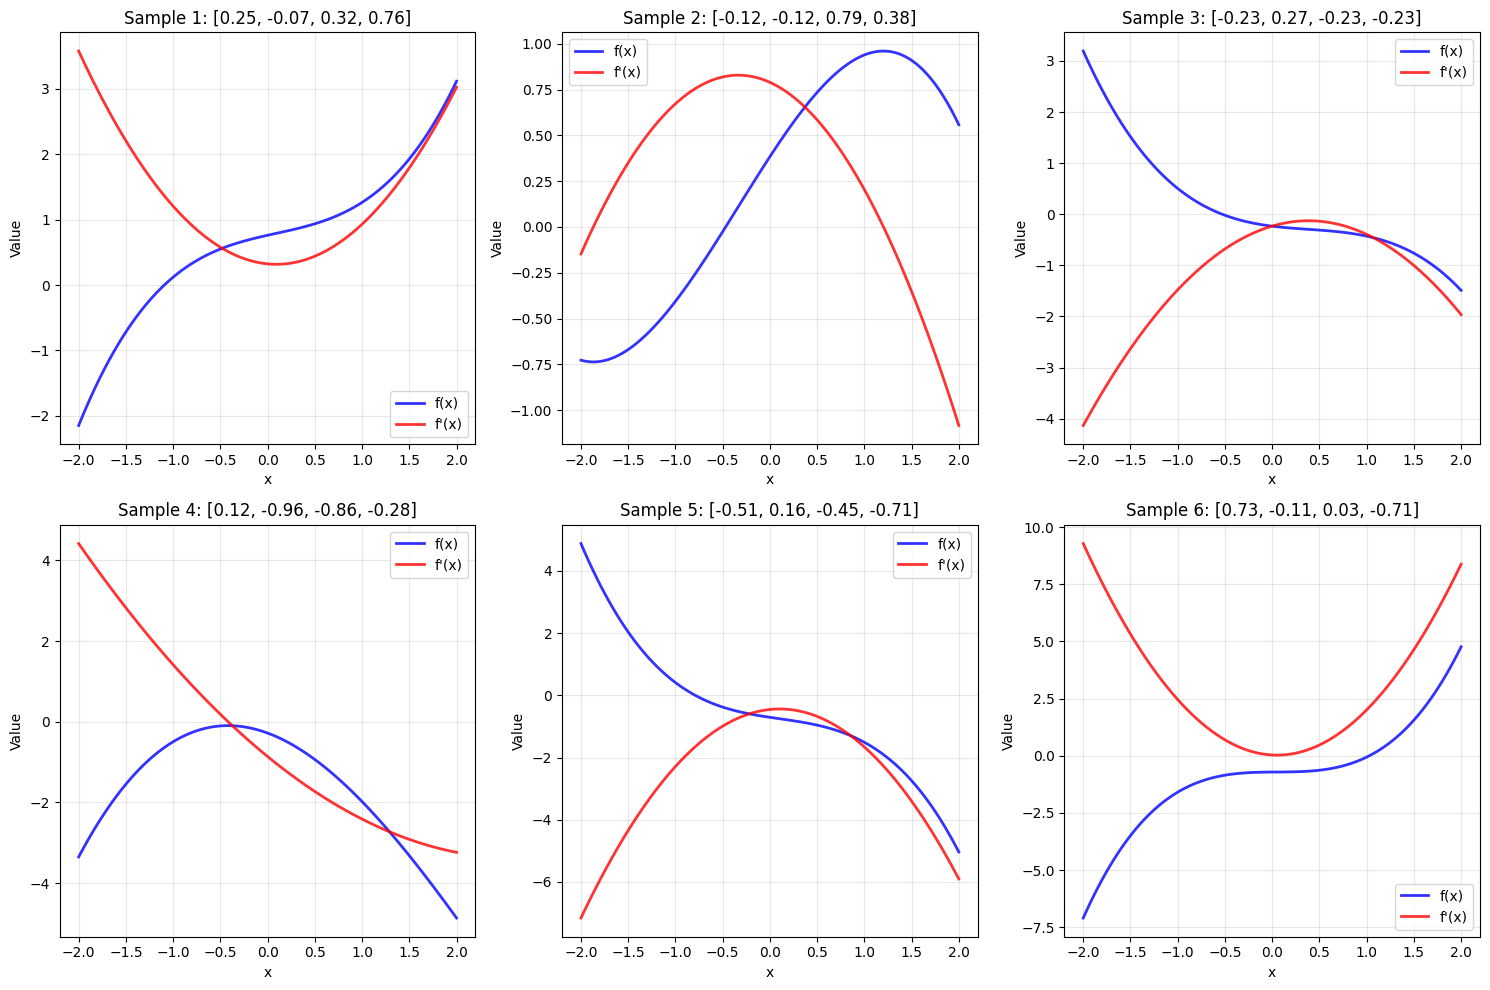


Mathematical relationships:
f(x) = ax³ + bx² + cx + d
f'(x) = 3ax² + 2bx + c
Goal: Learn operator mapping [a,b,c,d] → f'(x)


In [17]:
# ========================= CELL 1: Data Generation =========================
def generate_polynomial_data(num_functions=2000, num_points=100, x_range=(-2, 2)):
    """Generate cubic polynomial functions and their derivatives"""
    np.random.seed(42)
    
    # Generate random coefficients for cubic polynomials: ax^3 + bx^2 + cx + d
    coeffs = np.random.randn(num_functions, 4) * 0.5
    
    # Generate spatial points
    x = np.linspace(x_range[0], x_range[1], num_points)
    
    # Initialize arrays
    functions = np.zeros((num_functions, num_points))
    derivatives = np.zeros((num_functions, num_points))
    
    for i in range(num_functions):
        a, b, c, d = coeffs[i]
        # f(x) = ax^3 + bx^2 + cx + d
        functions[i] = a * x**3 + b * x**2 + c * x + d
        # f'(x) = 3ax^2 + 2bx + c
        derivatives[i] = 3 * a * x**2 + 2 * b * x + c
    
    return coeffs, x, functions, derivatives


print("=== POLYNOMIAL DATA GENERATION ===")
coeffs, x, functions, derivatives = generate_polynomial_data(num_functions=2000, num_points=100)

print(f"Generated {len(coeffs)} polynomial functions")
print(f"Coefficient shape: {coeffs.shape} (a, b, c, d for ax³+bx²+cx+d)")
print(f"Spatial domain: x ∈ [{x[0]:.1f}, {x[-1]:.1f}] with {len(x)} points")
print(f"Functions shape: {functions.shape}")
print(f"Derivatives shape: {derivatives.shape}")

# Visualize sample polynomials and their derivatives
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(6):
    ax = axes[i//3, i%3]
    
    # Plot function and derivative
    ax.plot(x, functions[i], 'b-', linewidth=2, label=f'f(x)', alpha=0.8)
    ax.plot(x, derivatives[i], 'r-', linewidth=2, label=f"f'(x)", alpha=0.8)
    
    # Show coefficients
    a, b, c, d = coeffs[i]
    ax.set_title(f'Sample {i+1}: [{a:.2f}, {b:.2f}, {c:.2f}, {d:.2f}]')
    ax.grid(True, alpha=0.3)
    ax.legend()
    ax.set_xlabel('x')
    ax.set_ylabel('Value')

plt.tight_layout()
plt.savefig('polynomial_samples.png', dpi=150)
plt.show()

# Print some mathematical relationships
print("\nMathematical relationships:")
print("f(x) = ax³ + bx² + cx + d")
print("f'(x) = 3ax² + 2bx + c")
print("Goal: Learn operator mapping [a,b,c,d] → f'(x)")


### DeepONet Implementation

In [18]:
class DeepONet(nn.Module):
    def __init__(self, branch_input_dim, trunk_input_dim, hidden_dim=32, num_basis=3):
        super(DeepONet, self).__init__()
        self.num_basis = num_basis
        self.hidden_dim = hidden_dim
        
        # Branch network - processes function coefficients
        self.branch_net = nn.Sequential(
            nn.Linear(branch_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        
        # Trunk network - processes spatial coordinates
        self.trunk_net = nn.Sequential(
            nn.Linear(trunk_input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, num_basis)
        )
        
        # Bias term
        self.bias = nn.Parameter(torch.zeros(1))
        
    def forward(self, branch_input, trunk_input):
        # Branch network output
        branch_out = self.branch_net(branch_input)  # [batch_size, num_basis]
        
        # Trunk network output - handle batch dimension
        if trunk_input.dim() == 3:  # [batch_size, num_points, 1]
            batch_size, num_points, _ = trunk_input.shape
            trunk_input_flat = trunk_input.view(-1, 1)  # [batch_size * num_points, 1]
            trunk_out = self.trunk_net(trunk_input_flat)  # [batch_size * num_points, num_basis]
            trunk_out = trunk_out.view(batch_size, num_points, self.num_basis)  # [batch_size, num_points, num_basis]
        else:  # [num_points, 1] - single evaluation
            trunk_out = self.trunk_net(trunk_input)  # [num_points, num_basis]
            trunk_out = trunk_out.unsqueeze(0)  # [1, num_points, num_basis]
        
        # Compute inner product
        output = torch.einsum('bi,bpi->bp', branch_out, trunk_out)
        
        return output + self.bias


print("\n=== DEEPONET ARCHITECTURE ===")
model = DeepONet(branch_input_dim=4, trunk_input_dim=1, hidden_dim=32, num_basis=3)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"DeepONet Architecture:")
print(f"- Branch input: 4 (polynomial coefficients [a,b,c,d])")
print(f"- Trunk input: 1 (spatial coordinate x)")
print(f"- Hidden dimension: {model.hidden_dim}")
print(f"- Number of basis functions: {model.num_basis}")
print(f"- Total parameters: {total_params:,}")
print(f"- Trainable parameters: {trainable_params:,}")


=== DEEPONET ARCHITECTURE ===
DeepONet Architecture:
- Branch input: 4 (polynomial coefficients [a,b,c,d])
- Trunk input: 1 (spatial coordinate x)
- Hidden dimension: 32
- Number of basis functions: 3
- Total parameters: 423
- Trainable parameters: 423


### Training


=== TRAINING ===
Data splits:
- Training batches: 13 (batch size: 128)
- Validation batches: 2
- Test samples: 200
\nStarting training...


Training DeepONet: 100%|██████████| 500/500 [00:29<00:00, 16.81it/s, Train=0.000439, Val=0.000770, LR=0.002500]


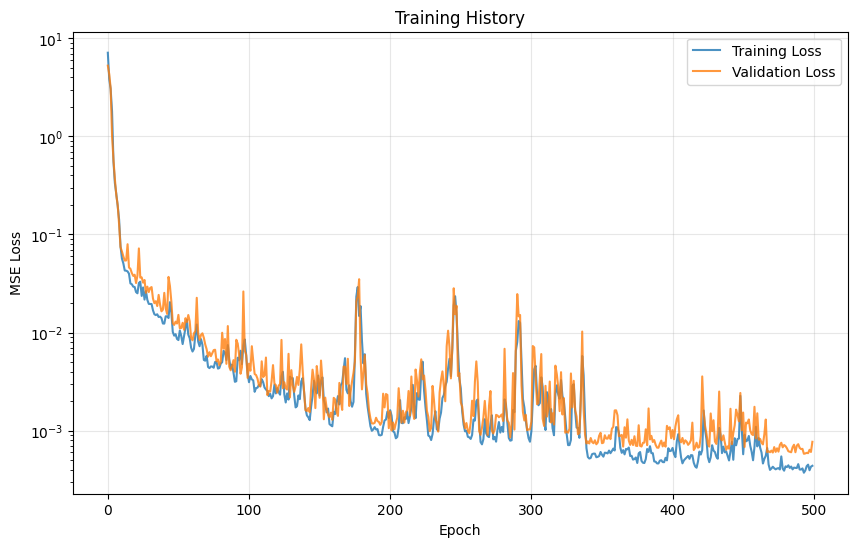

Training completed!
Final training loss: 0.000439
Final validation loss: 0.000770


In [19]:
def setup_data_loaders(coeffs, x, derivatives, batch_size=128):
    """Setup train/val/test data loaders"""
    # Split data
    train_size = int(0.8 * len(coeffs))
    val_size = int(0.1 * len(coeffs))
    
    train_coeffs = coeffs[:train_size]
    train_derivatives = derivatives[:train_size]
    
    val_coeffs = coeffs[train_size:train_size+val_size]
    val_derivatives = derivatives[train_size:train_size+val_size]
    
    test_coeffs = coeffs[train_size+val_size:]
    test_derivatives = derivatives[train_size+val_size:]
    
    # Convert to tensors
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1)
    
    # Create datasets - expand x_tensor for each function
    train_x = x_tensor.unsqueeze(0).repeat(len(train_coeffs), 1, 1)
    val_x = x_tensor.unsqueeze(0).repeat(len(val_coeffs), 1, 1)
    
    train_dataset = TensorDataset(
        torch.tensor(train_coeffs, dtype=torch.float32),
        train_x,
        torch.tensor(train_derivatives, dtype=torch.float32)
    )
    
    val_dataset = TensorDataset(
        torch.tensor(val_coeffs, dtype=torch.float32),
        val_x,
        torch.tensor(val_derivatives, dtype=torch.float32)
    )
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, (test_coeffs, test_derivatives)

def train_deeponet(model, train_loader, val_loader, num_epochs=500, lr=0.01):
    """Train the DeepONet model"""
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=50, factor=0.5)
    criterion = nn.MSELoss()
    
    train_losses = []
    val_losses = []
    
    best_val_loss = float('inf')
    patience = 100
    patience_counter = 0
    
    # Progress bar
    pbar = tqdm(range(num_epochs), desc="Training DeepONet")
    
    for epoch in pbar:
        # Training
        model.train()
        train_loss = 0.0
        for batch_coeffs, batch_x, batch_derivatives in train_loader:
            batch_coeffs = batch_coeffs.to(device)
            batch_x = batch_x.to(device)
            batch_derivatives = batch_derivatives.to(device)
            
            optimizer.zero_grad()
            output = model(batch_coeffs, batch_x)
            loss = criterion(output, batch_derivatives)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_coeffs, batch_x, batch_derivatives in val_loader:
                batch_coeffs = batch_coeffs.to(device)
                batch_x = batch_x.to(device)
                batch_derivatives = batch_derivatives.to(device)
                
                output = model(batch_coeffs, batch_x)
                loss = criterion(output, batch_derivatives)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        # Update progress bar
        pbar.set_postfix({
            'Train': f'{avg_train_loss:.6f}',
            'Val': f'{avg_val_loss:.6f}',
            'LR': f'{optimizer.param_groups[0]["lr"]:.6f}'
        })
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'\\nEarly stopping at epoch {epoch}')
                break
    
    pbar.close()
    return train_losses, val_losses

print("\n=== TRAINING ===")
train_loader, val_loader, test_data = setup_data_loaders(coeffs, x, derivatives, batch_size=128)

print(f"Data splits:")
print(f"- Training batches: {len(train_loader)} (batch size: 128)")
print(f"- Validation batches: {len(val_loader)}")
print(f"- Test samples: {len(test_data[0])}")

print("\\nStarting training...")
train_losses, val_losses = train_deeponet(model, train_loader, val_loader, num_epochs=500, lr=0.01)

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss', alpha=0.8)
plt.plot(val_losses, label='Validation Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training History')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.savefig('training_curves.png', dpi=150)
plt.show()

print(f"Training completed!")
print(f"Final training loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {val_losses[-1]:.6f}")

### Evaluation of model

\n=== PREDICTION & EVALUATION ===
Average Test MSE: 0.000778
Test MSE std: 0.003893


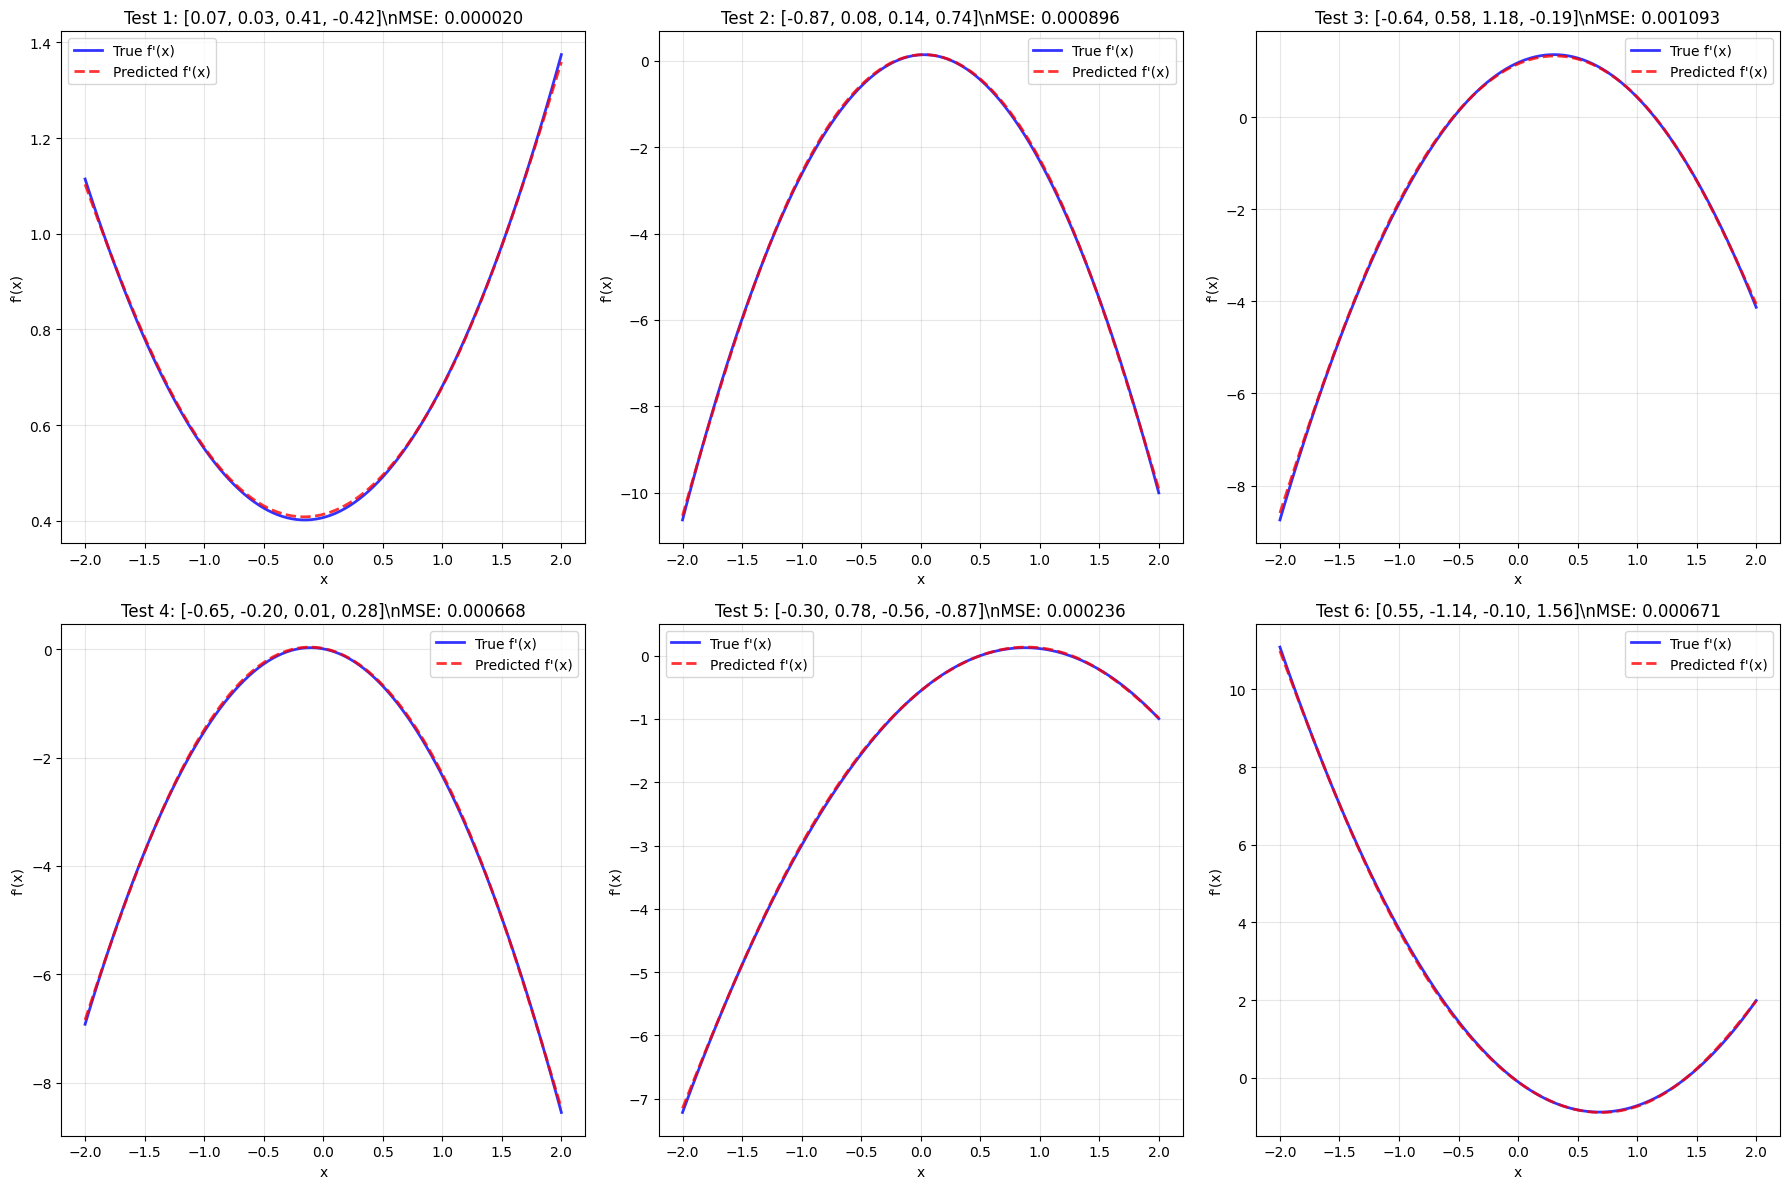

In [20]:
def evaluate_predictions(model, test_data, x):
    """Evaluate model predictions and create visualizations"""
    test_coeffs, test_derivatives = test_data
    model.eval()
    
    # Compute test errors
    test_errors = []
    predictions = []
    
    with torch.no_grad():
        for i in range(len(test_coeffs)):
            coeffs_tensor = torch.tensor(test_coeffs[i:i+1], dtype=torch.float32).to(device)
            x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
            
            predicted = model(coeffs_tensor, x_tensor).cpu().numpy().flatten()
            true_derivative = test_derivatives[i]
            
            mse = np.mean((predicted - true_derivative)**2)
            test_errors.append(mse)
            predictions.append(predicted)
    
    avg_test_mse = np.mean(test_errors)
    print(f"Average Test MSE: {avg_test_mse:.6f}")
    print(f"Test MSE std: {np.std(test_errors):.6f}")
    
    return predictions, test_errors

print("\\n=== PREDICTION & EVALUATION ===")
predictions, test_errors = evaluate_predictions(model, test_data, x)
test_coeffs, test_derivatives = test_data

# Plot prediction results
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot sample predictions
for i in range(6):
    ax = axes[i//3, i%3]
    
    ax.plot(x, test_derivatives[i], 'b-', linewidth=2, label='True f\'(x)', alpha=0.8)
    ax.plot(x, predictions[i], 'r--', linewidth=2, label='Predicted f\'(x)', alpha=0.8)
    
    # Show coefficients and error
    coeffs_str = ', '.join([f'{c:.2f}' for c in test_coeffs[i]])
    error = test_errors[i]
    ax.set_title(f'Test {i+1}: [{coeffs_str}]\\nMSE: {error:.6f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xlabel('x')
    ax.set_ylabel("f'(x)")

plt.tight_layout()
plt.savefig('prediction_results.png', dpi=150)
plt.show()


### Understanding What DeepONet Learned

**Critical question:** Did DeepONet truly learn the derivative operator, or just memorize patterns?

Let's test it on completely new types of functions it has never seen!

\n=== BASIS FUNCTION ANALYSIS ===
Extracting learned basis functions...
Branch Network Analysis:
Input polynomial term → Basis function weights
  ax³→3ax²: [2.9438, -2.1361, 3.2953]
  bx²→2bx: [0.3271, 1.0190, 0.4438]
  cx→c: [-0.4119, -0.1281, 0.4185]
  d→0: [0.0199, 0.0062, -0.0214]


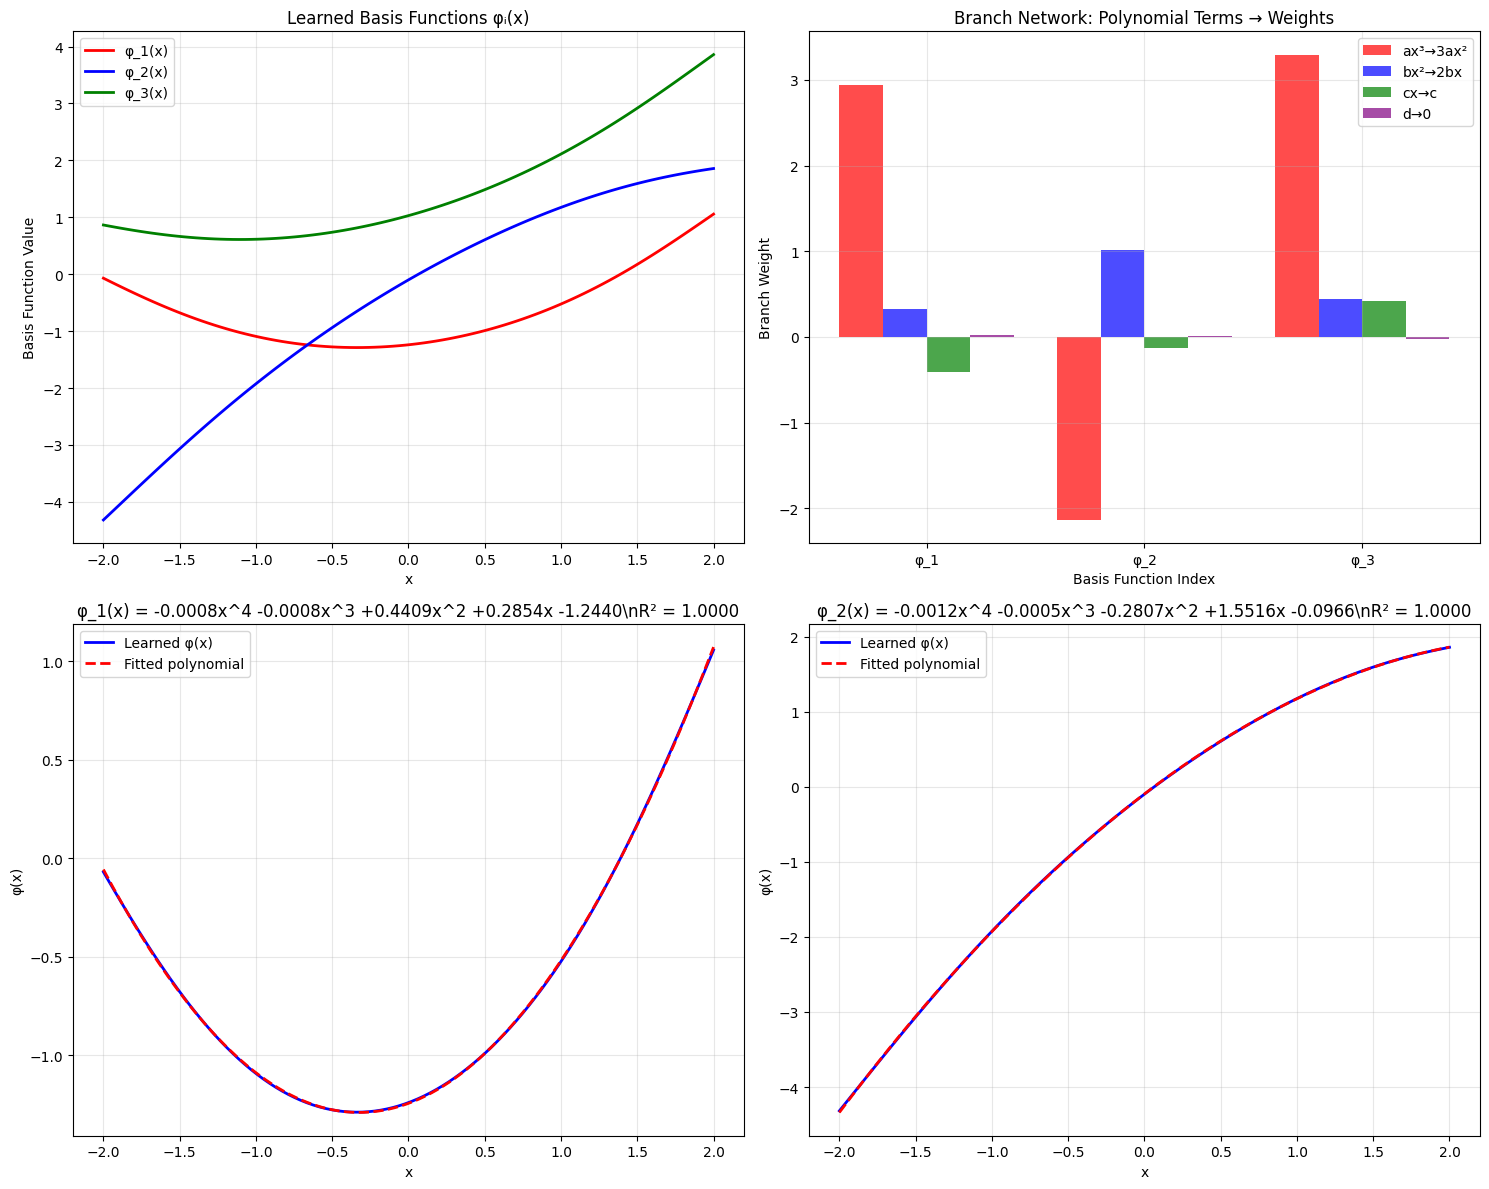

\n============================================================
DEEPONET MATHEMATICAL DECOMPOSITION
Original problem: Learn operator T: [a,b,c,d] → f'(x)
where f(x) = ax³ + bx² + cx + d
and f'(x) = 3ax² + 2bx + c

DeepONet solution: f'(x) ≈ Σᵢ₌₁³ wᵢ(a,b,c,d) × φᵢ(x) + bias

Learned basis functions:
  φ_1(x) = -0.0008x^4 -0.0008x^3 +0.4409x^2 +0.2854x -1.2440 (R² = 1.0000)
  φ_2(x) = -0.0012x^4 -0.0005x^3 -0.2807x^2 +1.5516x -0.0966 (R² = 1.0000)
  φ_3(x) = -0.0012x^4 +0.0005x^3 +0.3411x^2 +0.7492x +1.0264 (R² = 1.0000)


In [21]:
def extract_basis_equations(model, x_range=(-2, 2), num_points=1000):
    """Extract basis functions as polynomial equations by fitting"""
    model.eval()
    
    # Generate fine-grained x values for fitting
    x_fine = np.linspace(x_range[0], x_range[1], num_points)
    x_tensor = torch.tensor(x_fine, dtype=torch.float32).unsqueeze(1).to(device)
    
    with torch.no_grad():
        # Get trunk network outputs (basis functions)
        basis_outputs = model.trunk_net(x_tensor).cpu().numpy()  # [num_points, num_basis]
    
    # Fit polynomials to each basis function
    basis_equations = []
    
    for i in range(model.num_basis):
        y_basis = basis_outputs[:, i]
        
        # Try different polynomial degrees and pick the best fit
        best_coeffs = None
        best_degree = 0
        best_r2 = -np.inf
        
        for degree in range(1, 5):  # Try degrees 1-4
            try:
                coeffs = np.polyfit(x_fine, y_basis, degree)
                y_pred = np.polyval(coeffs, x_fine)
                
                # Calculate R² score
                ss_res = np.sum((y_basis - y_pred) ** 2)
                ss_tot = np.sum((y_basis - np.mean(y_basis)) ** 2)
                r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
                
                if r2 > best_r2:
                    best_r2 = r2
                    best_coeffs = coeffs
                    best_degree = degree
            except:
                continue
        
        # Format equation string
        equation = format_polynomial_equation(best_coeffs, best_degree)
        basis_equations.append({
            'coefficients': best_coeffs,
            'degree': best_degree,
            'equation': equation,
            'r2_score': best_r2,
            'function_values': y_basis,
            'x_values': x_fine
        })
    
    return basis_equations

def format_polynomial_equation(coeffs, degree):
    """Format polynomial coefficients as readable equation"""
    if coeffs is None:
        return "Unable to fit"
        
    terms = []
    
    for i, coeff in enumerate(coeffs):
        power = degree - i
        
        if abs(coeff) < 1e-6:  # Skip negligible terms
            continue
            
        # Format coefficient
        if len(terms) == 0:  # First term
            coeff_str = f"{coeff:.4f}"
        else:  # Subsequent terms
            coeff_str = f"{coeff:+.4f}"
        
        # Format power
        if power == 0:
            term = coeff_str
        elif power == 1:
            if abs(coeff - 1) < 1e-6:
                term = "x" if len(terms) == 0 else "+x"
            elif abs(coeff + 1) < 1e-6:
                term = "-x"
            else:
                term = f"{coeff_str}x"
        else:
            if abs(coeff - 1) < 1e-6:
                term = f"x^{power}" if len(terms) == 0 else f"+x^{power}"
            elif abs(coeff + 1) < 1e-6:
                term = f"-x^{power}"
            else:
                term = f"{coeff_str}x^{power}"
        
        terms.append(term)
    
    return " ".join(terms) if terms else "0"

def analyze_branch_behavior(model):
    """Analyze how branch network maps different polynomial types"""
    model.eval()
    
    # Test specific polynomial types
    sample_coeffs = np.array([
        [1, 0, 0, 0],  # Pure cubic: ax³ → 3ax²
        [0, 1, 0, 0],  # Pure quadratic: bx² → 2bx  
        [0, 0, 1, 0],  # Pure linear: cx → c
        [0, 0, 0, 1]   # Pure constant: d → 0
    ])
    
    coeffs_labels = ['ax³→3ax²', 'bx²→2bx', 'cx→c', 'd→0']
    
    print("Branch Network Analysis:")
    print("Input polynomial term → Basis function weights")
    
    with torch.no_grad():
        for coeffs, label in zip(sample_coeffs, coeffs_labels):
            coeffs_tensor = torch.tensor(coeffs.reshape(1, -1), dtype=torch.float32).to(device)
            branch_out = model.branch_net(coeffs_tensor).detach().cpu().numpy().flatten()
            
            weights_str = ', '.join([f'{w:.4f}' for w in branch_out])
            print(f"  {label}: [{weights_str}]")
    
    return sample_coeffs, coeffs_labels


print("\\n=== BASIS FUNCTION ANALYSIS ===")

# Extract basis functions
print("Extracting learned basis functions...")
basis_equations = extract_basis_equations(model, x_range=(-2, 2))

# Visualize basis functions
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: Basis functions
model.eval()
with torch.no_grad():
    x_tensor = torch.tensor(x, dtype=torch.float32).unsqueeze(1).to(device)
    trunk_features = model.trunk_net(x_tensor).cpu().numpy()
    
    colors = ['red', 'blue', 'green']
    for i in range(model.num_basis):
        axes[0,0].plot(x, trunk_features[:, i], linewidth=2, 
                label=f'φ_{i+1}(x)', color=colors[i])
    
    axes[0,0].set_xlabel('x')
    axes[0,0].set_ylabel('Basis Function Value')
    axes[0,0].set_title('Learned Basis Functions φᵢ(x)')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

# Plot 2: Branch network behavior
sample_coeffs, coeffs_labels = analyze_branch_behavior(model)

colors = ['red', 'blue', 'green', 'purple']
x_pos = np.arange(model.num_basis)
width = 0.2

for i, (coeffs, label) in enumerate(zip(sample_coeffs, coeffs_labels)):
    coeffs_tensor = torch.tensor(coeffs.reshape(1, -1), dtype=torch.float32).to(device)
    branch_out = model.branch_net(coeffs_tensor).detach().cpu().numpy().flatten()
    
    axes[0,1].bar(x_pos + i*width, branch_out, width, alpha=0.7, 
           label=label, color=colors[i])

axes[0,1].set_xlabel('Basis Function Index')
axes[0,1].set_ylabel('Branch Weight')
axes[0,1].set_title('Branch Network: Polynomial Terms → Weights')
axes[0,1].set_xticks(x_pos + 1.5*width)
axes[0,1].set_xticklabels([f'φ_{i+1}' for i in range(model.num_basis)])
axes[0,1].legend()
axes[0,1].grid(True, alpha=0.3)

# Plot 3-4: Individual basis functions with fitted equations
for i in range(min(2, model.num_basis)):
    ax = axes[1, i]
    basis_info = basis_equations[i]
    
    ax.plot(x, trunk_features[:, i], 'b-', linewidth=2, label='Learned φ(x)')
    
    # Plot fitted polynomial
    if basis_info['coefficients'] is not None:
        x_fine = np.linspace(x[0], x[-1], 200)
        y_fit = np.polyval(basis_info['coefficients'], x_fine)
        ax.plot(x_fine, y_fit, 'r--', linewidth=2, label='Fitted polynomial')
    
    ax.set_title(f'φ_{i+1}(x) = {basis_info["equation"]}\\nR² = {basis_info["r2_score"]:.4f}')
    ax.set_xlabel('x')
    ax.set_ylabel('φ(x)')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('basis_analysis.png', dpi=150)
plt.show()

# Print mathematical formulation
print("\\n" + "="*60)
print("DEEPONET MATHEMATICAL DECOMPOSITION")
print("="*60)
print("Original problem: Learn operator T: [a,b,c,d] → f'(x)")
print("where f(x) = ax³ + bx² + cx + d")
print("and f'(x) = 3ax² + 2bx + c")
print()
print("DeepONet solution: f'(x) ≈ Σᵢ₌₁³ wᵢ(a,b,c,d) × φᵢ(x) + bias")
print()
print("Learned basis functions:")
for i, basis_info in enumerate(basis_equations):
    print(f"  φ_{i+1}(x) = {basis_info['equation']} (R² = {basis_info['r2_score']:.4f})")


## The 1D Nonlinear Darcy Problem

**Now for something more challenging:** A real PDE with nonlinear physics!

### Problem Formulation

The 1D nonlinear Darcy equation models groundwater flow with solution-dependent permeability:

$$\frac{d}{dx}\left(-\kappa(u(x))\frac{du}{dx}\right) = f(x), \quad x \in [0,1]$$

where:
- **`u(x)`** is the **solution field** (e.g., pressure or hydraulic head).
- The **$\kappa(u)$:** is non-linear solution-dependent permeability is `κ(u(x)) = 0.2 + u^2(x)`.
- The **input term `f(x)`** is a Gaussian random field defined as `f(x) ~ GP(0, k(x, x'))` such that `k(x, x') = σ^2 exp(-||x - x'||^2 / (2ℓ_x^2))`, where `ℓ_x = 0.04` and `σ^2 = 1.0`.
- Homogeneous Dirichlet boundary conditions **`u(0) = 0`** and **`u(1) = 0`** are considered at the domain boundaries.

### The Operator Learning Challenge

**Goal:** Learn the solution operator $\mathcal{G}$ such that:
$$\mathcal{G}[f] = u$$

where $u$ is the solution to the nonlinear Darcy equation for source $f$.

**Key insight:** This is much harder than the derivative operator because:
1. **Nonlinear PDE:** No analytical solution
2. **Random sources:** Infinite variety of input functions
3. **Complex physics:** Solution depends on entire source profile

### Why This Matters

**Traditional approach:** For each new source $f$, solve the PDE numerically (expensive!)

**DeepONet approach:** Learn the operator once, then instant evaluation for any new source

### Let's examine the existing Darcy implementation

=== DATA GENERATION ===
Generating Darcy flow dataset...


Solving PDEs: 100%|██████████| 1000/1000 [00:08<00:00, 121.29it/s]


Dataset generated: 1000 functions, 40 points each
Input shape: torch.Size([1000, 40]), Output shape: torch.Size([1000, 40])


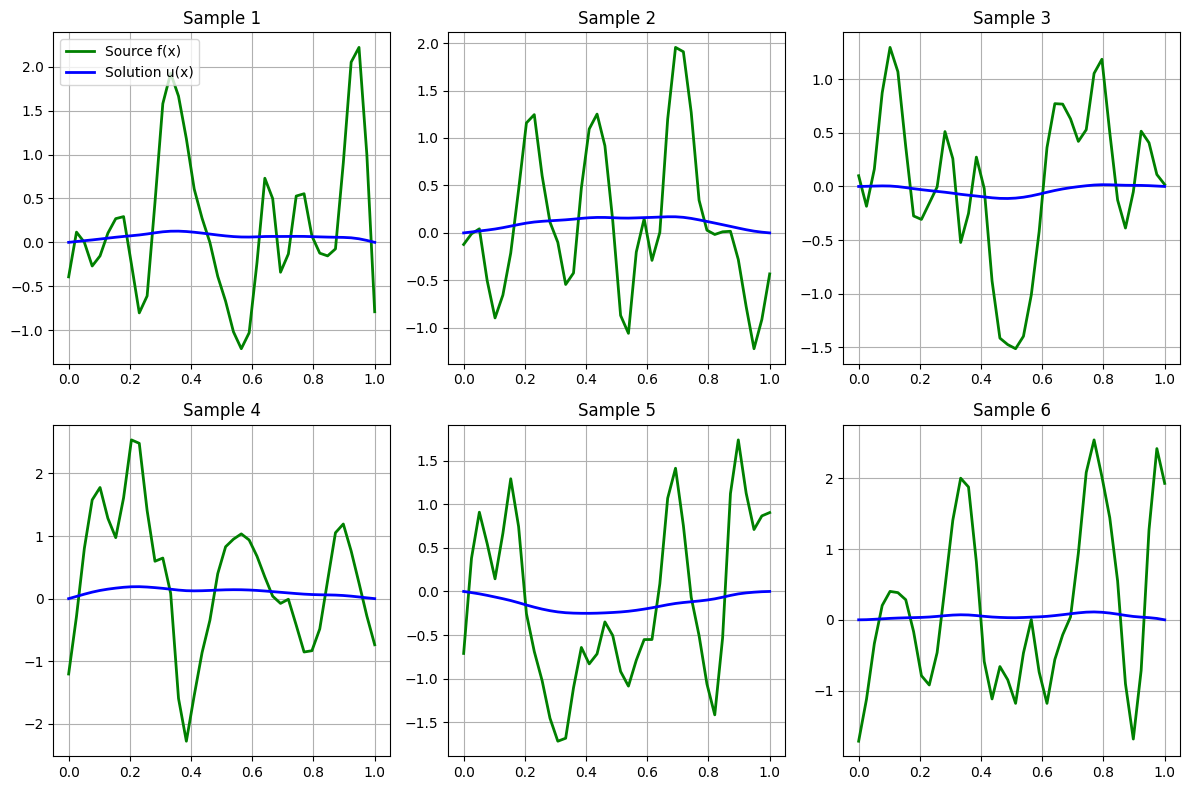

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.stats import multivariate_normal
from tqdm import tqdm

# ========================= CELL 1: Data Generation =========================
def generate_darcy_data(n_funcs=1000, n_points=40):
    """Generate 1D nonlinear Darcy flow data"""
    
    def permeability(s):
        return 0.2 + s**2
    
    # Gaussian process for source function
    x = np.linspace(0, 1, n_points)
    l, sigma = 0.04, 1.0
    K = sigma**2 * np.exp(-0.5 * (x[:, None] - x[None, :])**2 / l**2)
    K += 1e-6 * np.eye(n_points)
    
    def solve_darcy(u_func):
        dx = x[1] - x[0]
        s = np.zeros(n_points)
        
        for _ in range(100):  # Fixed point iteration
            kappa = permeability(s)
            main_diag = (kappa[1:] + kappa[:-1]) / dx**2
            upper_diag = -kappa[1:-1] / dx**2
            lower_diag = -kappa[1:-1] / dx**2
            
            A = diags([lower_diag, main_diag, upper_diag], [-1, 0, 1], 
                     shape=(n_points-2, n_points-2))
            
            s_interior = spsolve(A, u_func[1:-1])
            s_new = np.zeros(n_points)
            s_new[1:-1] = s_interior
            s = 0.5 * s_new + 0.5 * s
        
        return s
    
    # Generate dataset
    np.random.seed(42)
    X, U, S = [], [], []
    
    print("Generating Darcy flow dataset...")
    for i in tqdm(range(n_funcs), desc="Solving PDEs"):
        u = multivariate_normal.rvs(mean=np.zeros(n_points), cov=K)
        s = solve_darcy(u)
        X.append(x)
        U.append(u)
        S.append(s)
    
    X = torch.tensor(np.array(X), dtype=torch.float32)
    U = torch.tensor(np.array(U), dtype=torch.float32)
    S = torch.tensor(np.array(S), dtype=torch.float32)
    
    print(f"Dataset generated: {n_funcs} functions, {n_points} points each")
    print(f"Input shape: {U.shape}, Output shape: {S.shape}")
    
    return X, U, S


print("=== DATA GENERATION ===")
X, U, S = generate_darcy_data(n_funcs=1000, n_points=40)

# Plot samples
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
for i in range(6):
    ax = axes[i//3, i%3]
    ax.plot(X[i], U[i], 'g-', label='Source f(x)', linewidth=2)
    ax.plot(X[i], S[i], 'b-', label='Solution u(x)', linewidth=2)
    ax.set_title(f'Sample {i+1}')
    ax.grid(True)
    if i == 0:
        ax.legend()
plt.tight_layout()
plt.savefig('darcy_samples.png', dpi=150)
plt.show()

### DeepONet Architecture

In [23]:
class DeepONet(nn.Module):
    def __init__(self, branch_dim, trunk_dim, p_dim=128, hidden_dim=256):
        super().__init__()
        
        # Branch network (processes input function)
        self.branch = nn.Sequential(
            nn.Linear(branch_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, p_dim)
        )
        
        # Trunk network (processes query points)
        self.trunk = nn.Sequential(
            nn.Linear(trunk_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, p_dim)
        )
    
    def forward(self, u_vals, y_locs):
        branch_out = self.branch(u_vals)  # [batch, p_dim]
        trunk_out = self.trunk(y_locs)    # [batch, n_points, p_dim]
        
        # Dot product: sum over p_dim
        return torch.einsum('bp,bnp->bn', branch_out, trunk_out)


print("\n=== DEEPONET ARCHITECTURE ===")
print(f"Using device: {device}")

model = DeepONet(branch_dim=U.shape[1], trunk_dim=1, p_dim=128).to(device)

# Print model info
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


=== DEEPONET ARCHITECTURE ===
Using device: mps
Total parameters: 208,384
Trainable parameters: 208,384


### Training


=== TRAINING ===
Training samples: 800
Test samples: 200
Target normalization - Mean: -0.0046, Std: 0.1468
Starting training: 5000 epochs, batch size 64, lr 0.001


Training: 100%|██████████| 5000/5000 [00:24<00:00, 202.99it/s, Loss=0.001128, LR=9.67e-07]


Training completed!


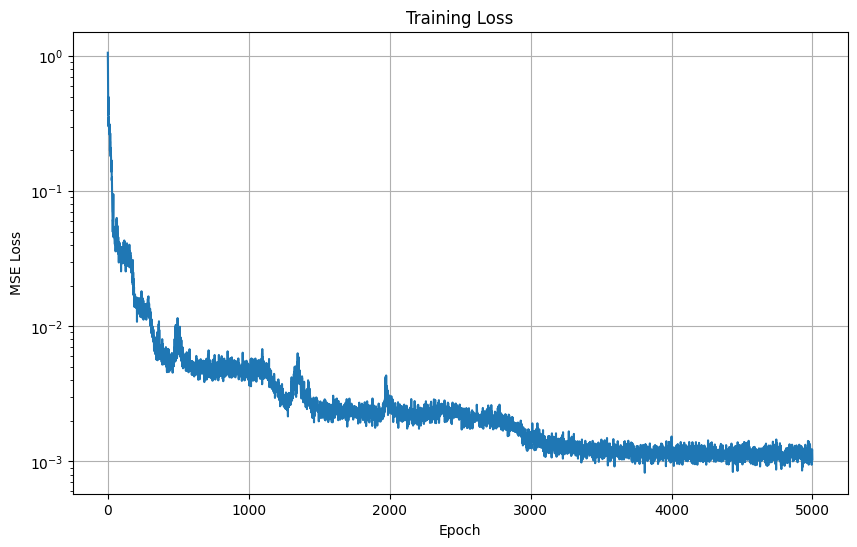

In [24]:
def setup_training(X, U, S, model, device):
    """Prepare data and optimizer for training"""
    # Split data
    n_train = int(0.8 * len(U))
    U_train, S_train = U[:n_train].to(device), S[:n_train].to(device)
    U_test, S_test = U[n_train:].to(device), S[n_train:].to(device)
    X_train, X_test = X[:n_train].to(device), X[n_train:].to(device)
    
    # Normalize targets
    S_mean, S_std = S_train.mean(), S_train.std()
    S_train_norm = (S_train - S_mean) / S_std
    S_test_norm = (S_test - S_mean) / S_std
    
    print(f"Training samples: {len(U_train)}")
    print(f"Test samples: {len(U_test)}")
    print(f"Target normalization - Mean: {S_mean:.4f}, Std: {S_std:.4f}")
    
    return (U_train, S_train_norm, X_train, U_test, S_test_norm, X_test, S_mean, S_std)

def train_model(model, train_data, epochs=5000, batch_size=64, lr=1e-3):
    """Train the DeepONet model"""
    U_train, S_train_norm, X_train, _, _, _, _, _ = train_data
    
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    
    print(f"Starting training: {epochs} epochs, batch size {batch_size}, lr {lr}")
    
    model.train()
    losses = []
    
    pbar = tqdm(range(epochs), desc="Training")
    for epoch in pbar:
        # Random batch
        idx = torch.randperm(len(U_train))[:batch_size]
        u_batch = U_train[idx]
        s_batch = S_train_norm[idx]
        x_batch = X_train[idx].unsqueeze(-1)  # [batch, n_points, 1]
        
        # Forward pass
        s_pred = model(u_batch, x_batch)
        loss = F.mse_loss(s_pred, s_batch)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(loss.item())
        
        if epoch % 100 == 0:
            pbar.set_postfix({
                'Loss': f'{loss.item():.6f}',
                'LR': f'{scheduler.get_last_lr()[0]:.2e}'
            })
    
    print("Training completed!")
    return losses


print("\n=== TRAINING ===")
train_data = setup_training(X, U, S, model, device)
losses = train_model(model, train_data, epochs=5000)

# Plot training loss
plt.figure(figsize=(10, 6))
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.yscale('log')
plt.grid(True)
plt.savefig('training_loss.png', dpi=150)
plt.show()


### DeepONet Prediction


=== PREDICTION & EVALUATION ===
Relative L2 error: 0.0306


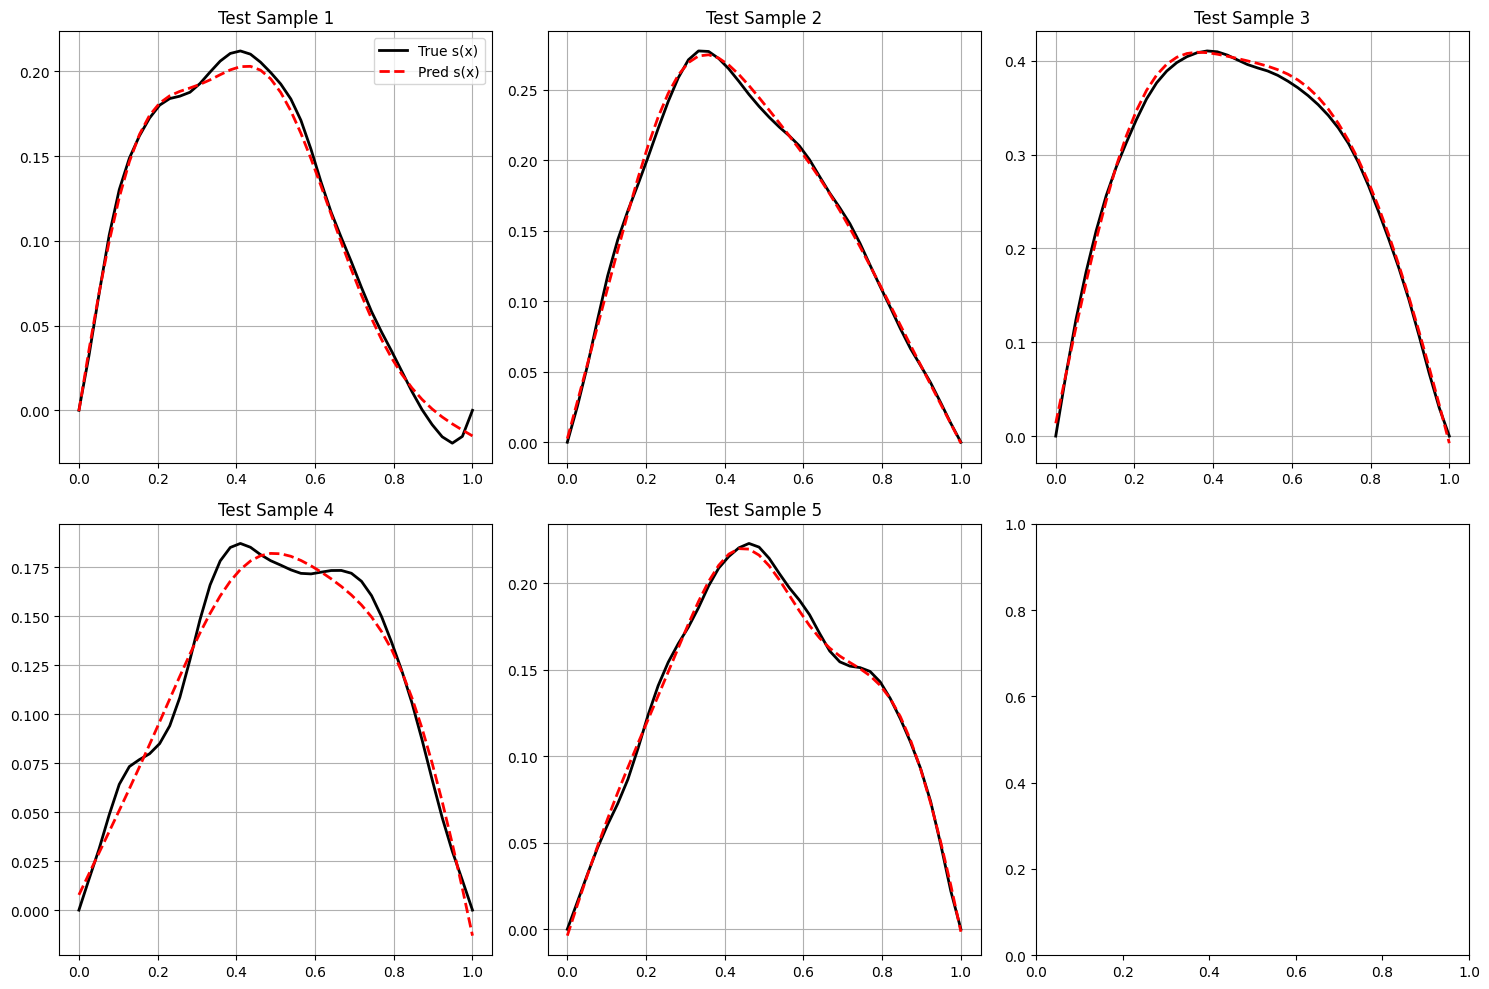

In [25]:
def evaluate_model(model, train_data):
    """Evaluate model and create visualizations"""
    U_train, S_train_norm, X_train, U_test, S_test_norm, X_test, S_mean, S_std = train_data
    
    model.eval()
    device = next(model.parameters()).device
    
    with torch.no_grad():
        # Test on first few samples
        n_test = min(5, len(U_test))
        u_test = U_test[:n_test]
        s_test_norm = S_test_norm[:n_test]
        x_test = X_test[:n_test].unsqueeze(-1)
        
        # Predict
        s_pred_norm = model(u_test, x_test)
        
        # Denormalize
        s_pred = s_pred_norm * S_std + S_mean
        s_test = s_test_norm * S_std + S_mean
        
        # Compute error
        l2_error = torch.sqrt(torch.mean((s_pred - s_test)**2) / torch.mean(s_test**2))
        print(f"Relative L2 error: {l2_error.item():.4f}")
        
        return s_pred, s_test, u_test, X_test

print("\n=== PREDICTION & EVALUATION ===")
s_pred, s_test, u_test, X_test = evaluate_model(model, train_data)

# Plot results
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i in range(min(6, len(s_pred))):
    ax = axes[i//3, i%3]
    x_np = X_test[i].cpu().numpy()
    
    ax.plot(x_np, s_test[i].cpu().numpy(), 'k-', label='True s(x)', linewidth=2)
    ax.plot(x_np, s_pred[i].cpu().numpy(), 'r--', label='Pred s(x)', linewidth=2)
    
    ax.set_title(f'Test Sample {i+1}')
    ax.grid(True)
    if i == 0:
        ax.legend()

plt.tight_layout()
plt.savefig('deeponet_results.png', dpi=150)
plt.show()


### Understanding basis functions


=== BASIS FUNCTION ANALYSIS ===
Extracted 128 basis functions
Each basis function has 40 points


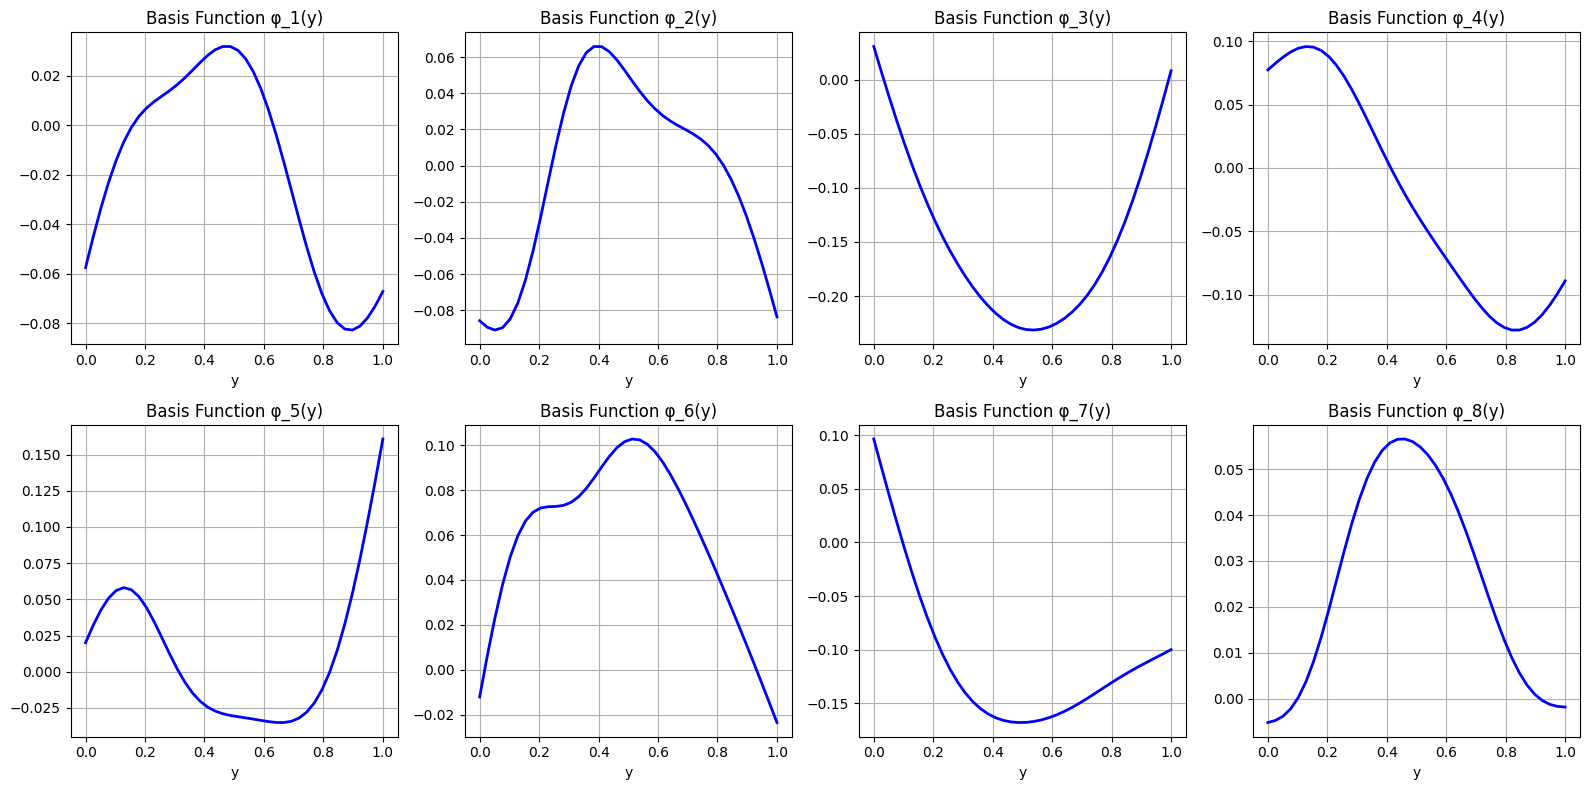

In [26]:
def extract_basis_functions(model, X_test):
    """Extract and visualize learned basis functions"""
    device = next(model.parameters()).device
    model.eval()
    
    with torch.no_grad():
        # Use test locations
        x_points = X_test[0].unsqueeze(0).unsqueeze(-1).to(device)  # [1, n_points, 1]
        
        # Get trunk network output (basis functions)
        trunk_out = model.trunk(x_points)  # [1, n_points, p_dim]
        basis_functions = trunk_out.squeeze(0).cpu().numpy()  # [n_points, p_dim]
        
        print(f"Extracted {basis_functions.shape[1]} basis functions")
        print(f"Each basis function has {basis_functions.shape[0]} points")
        
        return basis_functions

print("\n=== BASIS FUNCTION ANALYSIS ===")
basis_functions = extract_basis_functions(model, X_test)

# Plot first 8 basis functions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
x_np = X_test[0].cpu().numpy()

for i in range(8):
    ax = axes[i//4, i%4]
    ax.plot(x_np, basis_functions[:, i], 'b-', linewidth=2)
    ax.set_title(f'Basis Function φ_{i+1}(y)')
    ax.grid(True)
    ax.set_xlabel('y')

plt.tight_layout()
plt.savefig('basis_functions.png', dpi=150)
plt.show()


## Summary: 
### What We've Learned

1. **Conceptual Leap:** From function approximation to operator learning
   - Functions: $\mathbb{R}^d \rightarrow \mathbb{R}^m$ (point to point)
   - Operators: $\mathcal{F}_1 \rightarrow \mathcal{F}_2$ (function to function)

2. **Theoretical Foundation:** Universal Approximation Theorem for Operators
   - Neural networks can approximate operators!
   - Branch-trunk architecture emerges naturally
   - Basis function decomposition: $\mathcal{G}(u)(y) = \sum_k b_k(u) \cdot t_k(y)$

3. **Practical Implementation:** DeepONet architecture
   - **Branch network:** Encodes input functions into coefficients
   - **Trunk network:** Generates basis functions at query points
   - **Training:** Learn from input-output function pairs

4. **Real Applications:** From derivatives to nonlinear PDEs
   - **Derivative operator:** Perfect pedagogical example
   - **Darcy flow:** Real-world nonlinear PDE
   - **Generalization:** Works on unseen function types

### Key Advantages of DeepONet

✅ **Resolution independence:** Train on one grid, evaluate on any grid

✅ **Fast evaluation:** Once trained, instant prediction

✅ **Generalization:** Works for new functions not seen during training

✅ **Physical consistency:** Learns the underlying operator, not just patterns

### When to Use DeepONet

**Ideal scenarios:**
- **Parametric PDEs:** Need solutions for many different source terms/boundary conditions
- **Real-time applications:** Require instant evaluation
- **Complex geometries:** Traditional methods struggle
- **Multi-query problems:** Same operator, many evaluations

**Limitations:**
- **Training data:** Need many solved examples
- **Complex operators:** Very nonlinear mappings may be challenging
- **High dimensions:** Curse of dimensionality still applies

### The Bigger Picture

**DeepONet represents a paradigm shift:**
- Traditional numerical methods: Solve each problem instance
- **Operator learning:** Learn the solution pattern once, apply everywhere

This opens new possibilities for:
- **Inverse problems:** Learn parameter-to-solution mappings
- **Control applications:** Real-time system response
- **Multi-physics:** Coupled operator learning
- **Scientific discovery:** Understanding operator structure

---

**Next:** Combine with PINNs for physics-informed operator learning!

## Further Reading and Extensions

### Key Papers
1. **[Lu et al. (2019)](https://arxiv.org/abs/1910.03193)** - Original DeepONet paper
2. **[Goswami et al. (2023)](https://arxiv.org/pdf/2207.05748)** - Physics-informed DeepONets
3. **[Chen & Chen (1995)](https://link.springer.com/article/10.1007/BF02551274)** - Universal approximation theorem for operators

### Extensions to Explore
- **Multi-output operators:** Vector-valued mappings
- **Higher dimensions:** 2D/3D PDEs
- **Physics-informed training:** Incorporate governing equations
- **Fourier Neural Operators:** Alternative operator learning architecture

### Exercises
1. **Modify the derivative example** to learn the second derivative operator
2. **Extend to 2D** by implementing the Laplacian operator $\nabla^2 u$
3. **Add physics constraints** by incorporating the differential equation into the loss
4. **Compare with traditional methods** on computational efficiency

The journey from function approximation to operator learning represents one of the most exciting frontiers in scientific machine learning!